In [10]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.16.3
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# # Giai đoạn 4: Huấn luyện ML – Phiên bản SẠCH (v2)
# 
# **Mục tiêu**:
# - **Nhãn sạch**: `Anomaly_GT` = `(Label != '-')` → **không dùng `Severity` để tạo label**
# - **Features sạch**: Không dùng `Label`, `Severity`, `Anomaly` trong features
# - **Train / Val / Test**: 60% / 20% / 20% theo thời gian
# - **Model**: Isolation Forest (tune `contamination`)
# - **Prophet**: Dự báo số lượng anomaly **chỉ dựa trên `Label`**
# - **Không leakage** – Đánh giá trung thực

# In[1]: Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

# Đường dẫn
BASE_PATH = Path(r"C:\Users\Admin\Intelligent-Log-Analysis-and-Anomaly-Detection-Assistant-using-RAG-and-LLMs")
DATA_PATH = BASE_PATH / "data" / "processed" / "BGL_preprocessed.csv"
MODELS_PATH = BASE_PATH / "models"
MODELS_PATH.mkdir(exist_ok=True)

print("Setup complete.")

Setup complete.


In [11]:
# In[2]: Load & Tạo nhãn sạch
df = pd.read_csv(DATA_PATH, low_memory=False)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp']).sort_values('Timestamp').reset_index(drop=True)

# NHÃN SẠCH: Chỉ dùng Label gốc
df['Anomaly_GT'] = (df['Label'] != '-').astype(int)

print(f"Loaded {len(df):,} logs")
print(f"Anomaly_GT ratio: {df['Anomaly_GT'].mean():.4f} ({df['Anomaly_GT'].sum():,} anomalies)")
print(f"Time range: {df['Timestamp'].min()} → {df['Timestamp'].max()}")

Loaded 100,000 logs
Anomaly_GT ratio: 0.0261 (2,609 anomalies)
Time range: 2005-06-03 15:42:50.363779 → 2005-06-05 09:38:26.892021


In [12]:
# In[3]: Chia dữ liệu theo thời gian
train_end = int(len(df) * 0.60)
val_end   = int(len(df) * 0.80)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

print(f"Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")
print(f"Train dates: {train_df['Timestamp'].min()} → {train_df['Timestamp'].max()}")

Train: 60,000 | Val: 20,000 | Test: 20,000
Train dates: 2005-06-03 15:42:50.363779 → 2005-06-05 06:47:40.022959


In [13]:
# In[4]: Xây dựng Preprocessor – KHÔNG DÙNG NHÃN
def build_preprocessor(train_df):
    df = train_df.copy()
    
    # Xử lý Keywords
    df['Keywords'] = df['Keywords'].fillna('').astype(str).str.strip()
    top_k = df['Keywords'].value_counts().head(100).index
    df.loc[~df['Keywords'].isin(top_k), 'Keywords'] = 'other'
    
    # Chỉ dùng Component (không dùng Severity, Label)
    df['Component'] = df['Component'].astype(str)
    
    numeric_features = ['Latency', 'MsgLength', 'Hour', 'DayOfWeek']
    categorical_features = ['Component', 'Keywords']  # <-- SẠCH
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(
                handle_unknown='ignore',
                max_categories=50,
                sparse_output=False
            ), categorical_features)
        ],
        remainder='drop'
    )
    
    X = df[numeric_features + categorical_features]
    preprocessor.fit(X)
    return preprocessor

preprocessor = build_preprocessor(train_df)
joblib.dump(preprocessor, MODELS_PATH / "preprocessor_clean.pkl")
print(f"Preprocessor saved: {MODELS_PATH / 'preprocessor_clean.pkl'}")

Preprocessor saved: C:\Users\Admin\Intelligent-Log-Analysis-and-Anomaly-Detection-Assistant-using-RAG-and-LLMs\models\preprocessor_clean.pkl


In [14]:
# In[5]: Biến đổi dữ liệu + Lấy nhãn sạch
def transform_data(df, preprocessor):
    df = df.copy()
    df['Keywords'] = df['Keywords'].fillna('').astype(str).str.strip()
    
    # Lấy danh sách Keywords từ preprocessor
    cat_features = preprocessor.named_transformers_['cat']
    keyword_cats = cat_features.categories_[1]  # Keywords là cột thứ 2
    df.loc[~df['Keywords'].isin(keyword_cats), 'Keywords'] = 'other'
    
    df['Component'] = df['Component'].astype(str)
    
    numeric_features = ['Latency', 'MsgLength', 'Hour', 'DayOfWeek']
    categorical_features = ['Component', 'Keywords']
    
    X = preprocessor.transform(df[numeric_features + categorical_features])
    y = (df['Label'] != '-').astype(int).values  # <-- NHÃN SẠCH
    return X, y

X_train, y_train = transform_data(train_df, preprocessor)
X_val,   y_val   = transform_data(val_df,   preprocessor)
X_test,  y_test  = transform_data(test_df,  preprocessor)

print(f"X_train: {X_train.shape} | X_val: {X_val.shape} | X_test: {X_test.shape}")

X_train: (60000, 55) | X_val: (20000, 55) | X_test: (20000, 55)


In [15]:
# In[6]: Model Selection – Tune Isolation Forest
best_f1 = 0
best_model = None
best_cont = None

print("Tuning contamination...")
for cont in [0.03, 0.05, 0.06, 0.07, 0.08]:
    model = IsolationForest(
        contamination=cont,
        random_state=42,
        n_estimators=100
    )
    model.fit(X_train)
    pred_val = model.predict(X_val)
    pred_val = np.where(pred_val == 1, 0, 1)
    f1 = f1_score(y_val, pred_val)
    print(f"  cont={cont:.3f} → F1={f1:.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_cont = cont

print(f"\nBest: contamination={best_cont}, F1={best_f1:.3f}")

Tuning contamination...
  cont=0.030 → F1=0.069
  cont=0.050 → F1=0.314
  cont=0.060 → F1=0.246
  cont=0.070 → F1=0.194
  cont=0.080 → F1=0.189

Best: contamination=0.05, F1=0.314



FINAL EVALUATION ON TEST SET
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     19956
     Anomaly       0.25      1.00      0.39        44

    accuracy                           0.99     20000
   macro avg       0.62      1.00      0.70     20000
weighted avg       1.00      0.99      1.00     20000



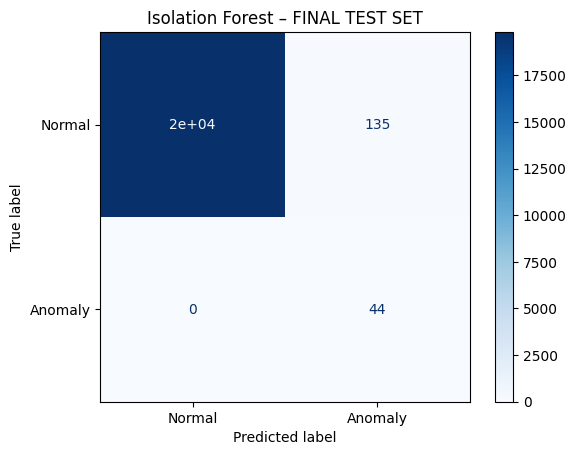

Model saved: C:\Users\Admin\Intelligent-Log-Analysis-and-Anomaly-Detection-Assistant-using-RAG-and-LLMs\models\isolation_forest_clean.pkl


In [16]:
# In[7]: Đánh giá cuối cùng trên TEST
final_pred = best_model.predict(X_test)
final_pred = np.where(final_pred == 1, 0, 1)

print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)
print(classification_report(y_test, final_pred, target_names=['Normal', 'Anomaly']))

cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title('Isolation Forest – FINAL TEST SET')
plt.show()

# Lưu model
joblib.dump(best_model, MODELS_PATH / "isolation_forest_clean.pkl")
print(f"Model saved: {MODELS_PATH / 'isolation_forest_clean.pkl'}")

11:19:50 - cmdstanpy - INFO - Chain [1] start processing
11:19:50 - cmdstanpy - INFO - Chain [1] done processing



Prophet MAE on TEST: 1070.59 anomalies/day


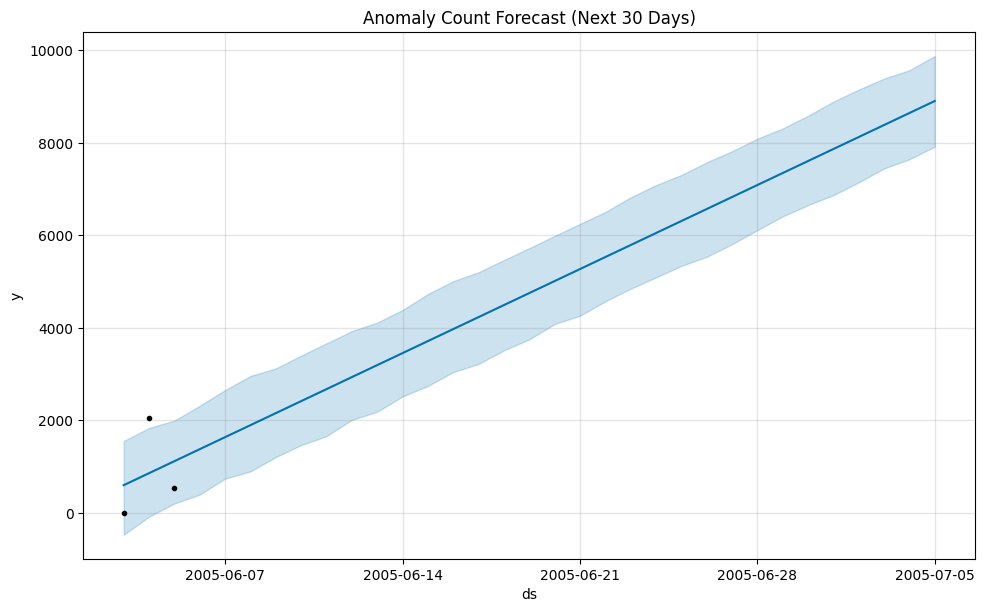

['C:\\Users\\Admin\\Intelligent-Log-Analysis-and-Anomaly-Detection-Assistant-using-RAG-and-LLMs\\models\\prophet_clean.pkl']

In [17]:
# In[8]: Prophet – Dự báo số lượng anomaly (dựa trên Label)
train_val_df = pd.concat([train_df, val_df])
daily_train = (train_val_df
               .resample('D', on='Timestamp')['Anomaly_GT']
               .sum()
               .reset_index()
               .rename(columns={'Timestamp': 'ds', 'Anomaly_GT': 'y'}))

prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=False)
prophet_model.fit(daily_train)

# Forecast
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Đánh giá trên TEST
test_daily = (test_df
              .resample('D', on='Timestamp')['Anomaly_GT']
              .sum()
              .reset_index()
              .rename(columns={'Timestamp': 'ds', 'Anomaly_GT': 'y'}))

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(
    test_daily['y'],
    forecast.loc[forecast['ds'].isin(test_daily['ds']), 'yhat']
)
print(f"\nProphet MAE on TEST: {mae:.2f} anomalies/day")

# Vẽ
fig = prophet_model.plot(forecast)
plt.title("Anomaly Count Forecast (Next 30 Days)")
plt.show()

# Lưu
joblib.dump(prophet_model, MODELS_PATH / "prophet_clean.pkl")

In [18]:
# In[9]: Tóm tắt
print("\n" + "="*60)
print("TÓM TẮT KẾT QUẢ (PHIÊN BẢN SẠCH)")
print("="*60)
print(f"Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")
print(f"Best contamination: {best_cont}")
print(f"Validation F1: {best_f1:.3f}")
print(f"Test F1 (anomaly): {f1_score(y_test, final_pred):.3f}")
print(f"Prophet MAE (test): {mae:.2f}")
print("="*60)
print("Tất cả model đã lưu trong /models/ (phiên bản sạch)")


TÓM TẮT KẾT QUẢ (PHIÊN BẢN SẠCH)
Train: 60,000 | Val: 20,000 | Test: 20,000
Best contamination: 0.05
Validation F1: 0.314
Test F1 (anomaly): 0.395
Prophet MAE (test): 1070.59
Tất cả model đã lưu trong /models/ (phiên bản sạch)
